<a href="https://colab.research.google.com/github/Siyatell/siyademo/blob/main/IntensityMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load images function
def load_images(path, color_channels=1):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            if color_channels == 1:  # Grayscale images
                img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
            elif color_channels == 3:  # RGB images
                img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return np.array(images)

# Set paths to your images (SAR grayscale and RGB colored images)
s1_path = '/content/drive/MyDrive/agri/s1'  # Grayscale (SAR)
s2_path = '/content/drive/MyDrive/agri/s2'  # RGB (Ground truth)

# Load the SAR grayscale images and RGB images
sar_images = load_images(s1_path, color_channels=1)  # Grayscale SAR images
rgb_images = load_images(s2_path, color_channels=3)  # Colored (RGB) ground truth images

# Normalize images to the range [0, 1]
sar_images = sar_images.astype('float32') / 255.0
rgb_images = rgb_images.astype('float32') / 255.0

# Manually split the dataset into training and testing (first 1000 for training, next 200 for testing)
X_train = sar_images[:500]  # First 500 images for training
y_train = rgb_images[:500]  # First 500 RGB images for training

X_test = sar_images[500:600]  # Next 100 images for testing
y_test = rgb_images[500:600]  # Next 100 RGB images for testing

# Check the shape of the splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (500, 256, 256, 1), (500, 256, 256, 3)
Testing data shape: (100, 256, 256, 1), (100, 256, 256, 3)


In [ ]:
# Define U-Net Model
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottom (Bottleneck)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)

    # Create model
    model = models.Model(inputs, outputs)

    return model

# Instantiate the U-Net model
model = unet_model((256, 256, 1))  # 256x256 grayscale images
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,723 (118.37 MB)

 Trainable params: 31,030,723 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3486s 109s/step - accuracy: 0.5332 - loss: 0.0686 - val_accuracy: 0.7582 - val_loss: 0.0433
4/4 ━━━━━━━━━━━━━━━━━━━━ 191s 43s/step - accuracy: 0.7541 - loss: 0.0427
Test Loss: 0.043322931975126266
Test Accuracy: 0.7581670880317688


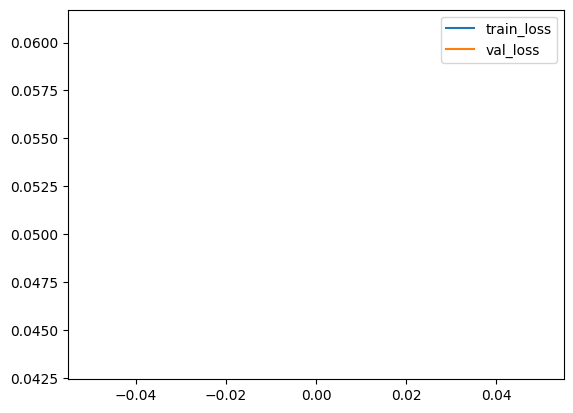

4/4 ━━━━━━━━━━━━━━━━━━━━ 196s 45s/step


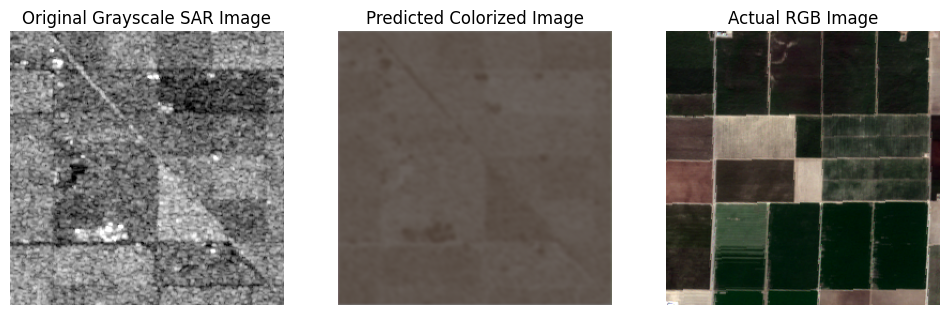

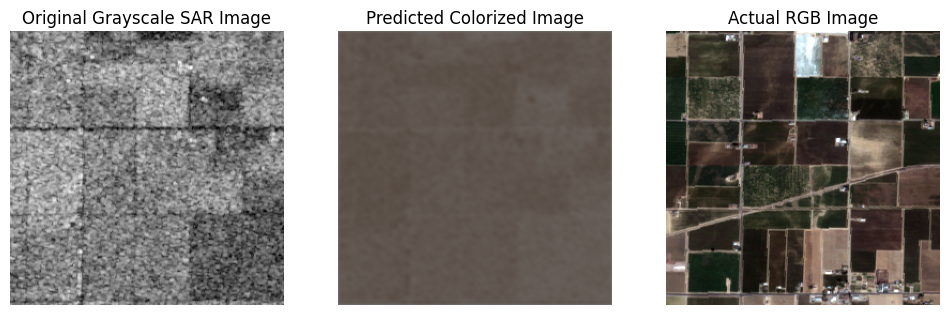

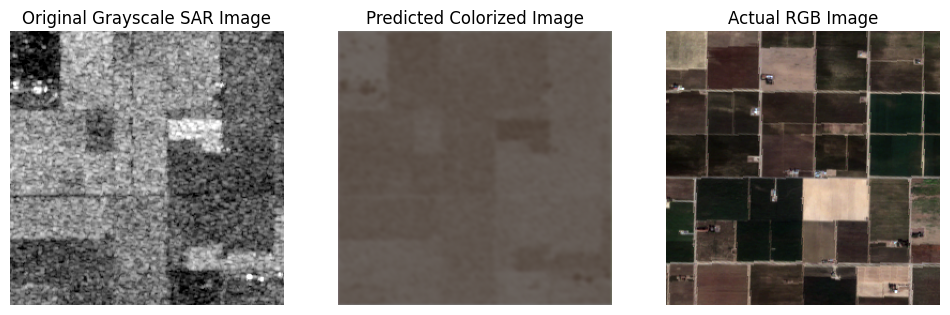

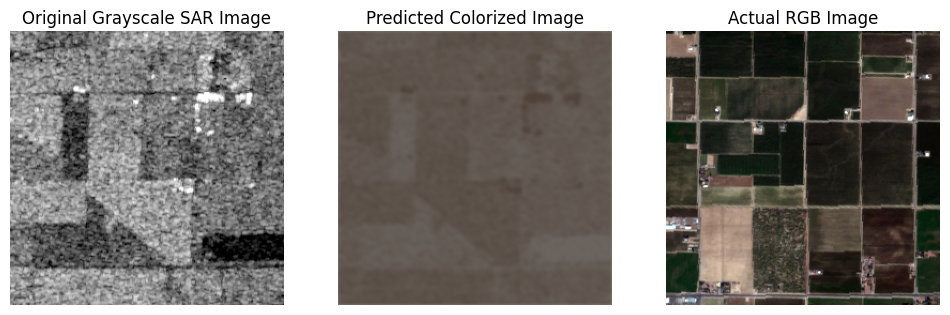

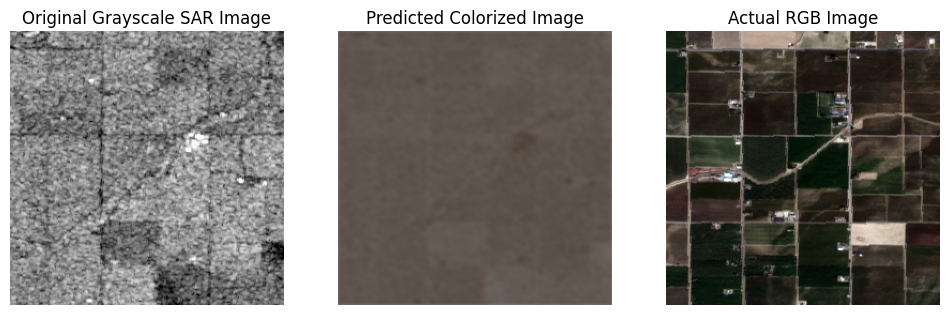

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=16)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Display the results (Original, Predicted, Actual)
num_images = 5  # Number of test images to display
for i in range(num_images):
    # Plot the original SAR image, predicted colorized image, and actual RGB image
    plt.figure(figsize=(12, 4))

    # Original SAR image (grayscale)
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Original Grayscale SAR Image")
    plt.axis('off')

    # Predicted colorized image
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i])
    plt.title("Predicted Colorized Image")
    plt.axis('off')

    # Actual RGB image (ground truth)
    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i])
    plt.title("Actual RGB Image")
    plt.axis('off')

    plt.show()

# Save the trained model
model.save('/content/drive/MyDrive/sar_colorization_unet.h5')

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 3547s 111s/step - accuracy: 0.7027 - loss: 0.0567 - val_accuracy: 0.7582 - val_loss: 0.0425
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 3514s 110s/step - accuracy: 0.6871 - loss: 0.0568 - val_accuracy: 0.7582 - val_loss: 0.0413
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 3533s 109s/step - accuracy: 0.7097 - loss: 0.0549 - val_accuracy: 0.7582 - val_loss: 0.0431
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 3536s 111s/step - accuracy: 0.7081 - loss: 0.0568 - val_accuracy: 0.7582 - val_loss: 0.0441
4/4 ━━━━━━━━━━━━━━━━━━━━ 191s 43s/step - accuracy: 0.7541 - loss: 0.0437
Test Loss: 0.04412886127829552
Test Accuracy: 0.758189857006073


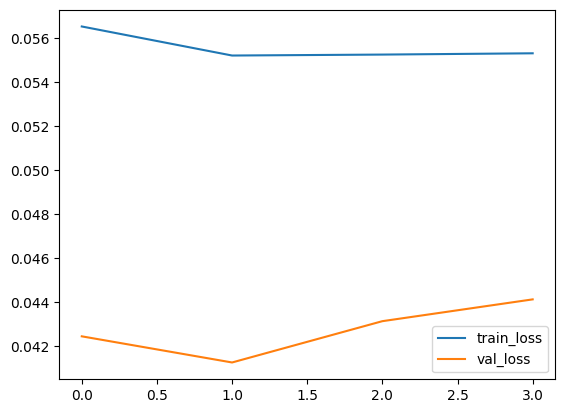

4/4 ━━━━━━━━━━━━━━━━━━━━ 202s 47s/step


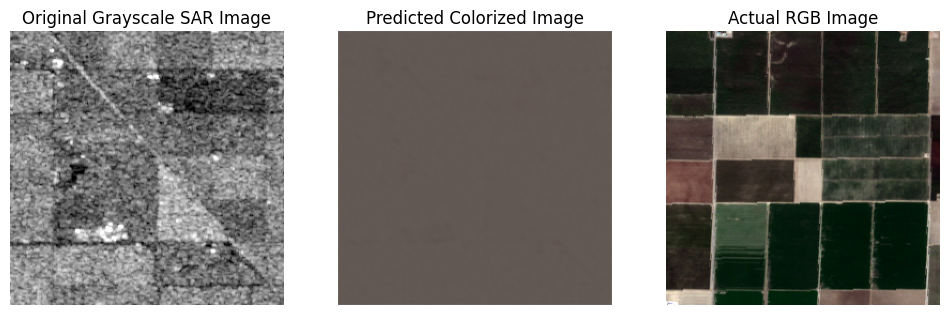

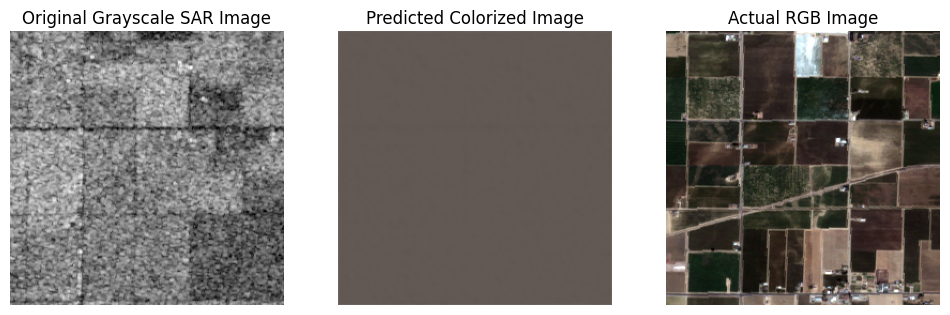

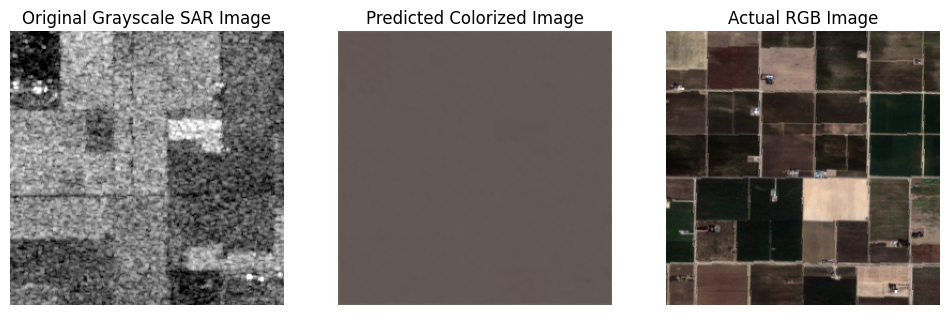

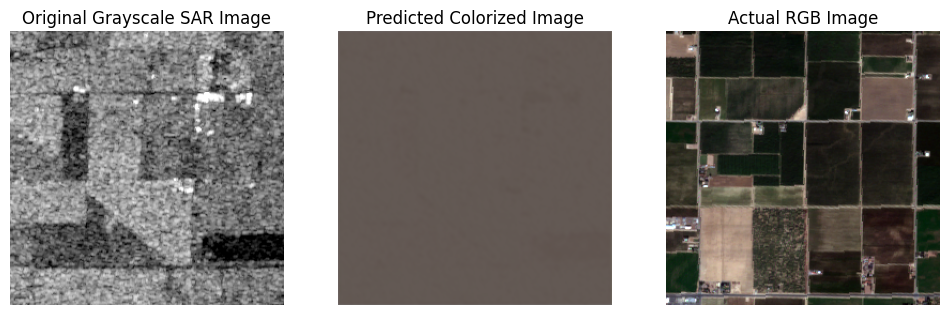

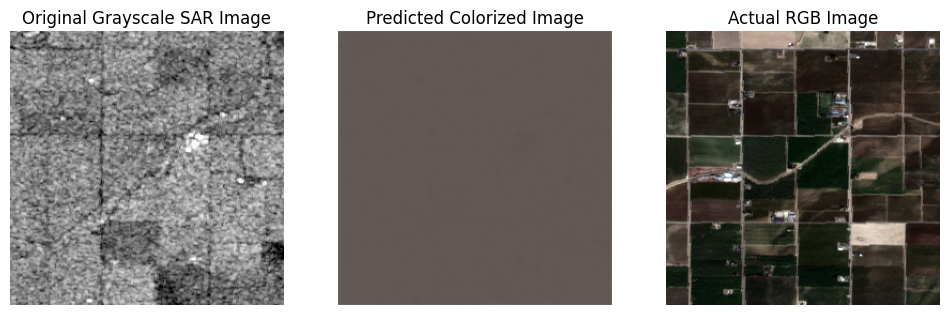

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=16)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Display the results (Original, Predicted, Actual)
num_images = 5  # Number of test images to display
for i in range(num_images):
    # Plot the original SAR image, predicted colorized image, and actual RGB image
    plt.figure(figsize=(12, 4))

    # Original SAR image (grayscale)
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Original Grayscale SAR Image")
    plt.axis('off')

    # Predicted colorized image
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i])
    plt.title("Predicted Colorized Image")
    plt.axis('off')

    # Actual RGB image (ground truth)
    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i])
    plt.title("Actual RGB Image")
    plt.axis('off')

    plt.show()

# Save the trained model
model.save('/content/drive/MyDrive/sar_colorization_unet.h5')